# **Advanced Lane Finding** 
***
The main goals of this project are:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

## **Import Packages**

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import glob
import collections
import os
import pickle
from Video_Processing import *
%matplotlib inline

## **Read an Image**

The image type is <class 'numpy.ndarray'>
The dimensions are: (720, 1280, 3)


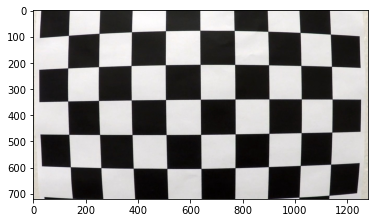

In [2]:
image = mpimg.imread('camera_cal/calibration1.jpg')
#print some stats
print('The image type is', type(image))
print('The dimensions are:', image.shape)
#Plot the image
plt.imshow(image)

## **User-Defined Functions**

In [3]:
# Define all required functions:
# 1.camera_calibrate() - Inputs chess board size, path to open & save images. Returns object points/
# image points requried to calibrate the camera and undistort an image
def camera_calibrate(ChessBoardSize,path_open,path_save):
    x = ChessBoardSize[0]
    y = ChessBoardSize[1]
    
    ## Prepare object points
    objp = np.zeros((x*y,3), np.float32)
    objp[:,:2] = np.mgrid[0:x, 0:y].T.reshape(-1,2)
    
    ## Local arrays to store object & image points from all the images
    objpoints = []
    imgpoints = []
    
    ## List all calibration images
    images = glob.glob(path_open) # Saves all images in "camera_cal" folder
    errcount = 0 # Counter for images whose corners cant be found
    for fname in images:
        img = cv2.imread(fname) # Read in the images
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        
        ## Find the Chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (x,y), None)
        # If corners are found, append object & image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
            
            # Draw images to visualsie the corners
            cv2.drawChessboardCorners(img, (9,6), corners, ret)
            #print(fname)
            #plt.imshow(img)
            #plt.show()
            
            # Save Images to the folder camera_cal_save
            path=os.path.split(fname) # Split the Image name 
            save_name = path_save+path[1]+'_corners_found'+'.jpg'
            cv2.imwrite(save_name,img)
        else:
            errcount +=1
    
    print("The number of images whose corners cannot be found:",str(errcount))
    
    return objpoints, imgpoints

# 2. cal_undistort() - Inputs the img, object and image points to calibrate the camera and outputs
# the undistorted image
def cal_undistort(img, objpoints, imgpoints):
    # Calibrate the camera
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[1::-1], None, None)
    
    # Undistort the Image
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    return mtx, dist, dst

# 3. abs_sobel_thresh() - Inputs the img, orientation, kernel size and thresholds and applies
# Sobel 'x' or 'y'. Finally takes the absolute value, applies the threshold and returns a binary image
def abs_sobel_thresh(img, orient='x', sobel_kernel=9, thresh=(0,255)):
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) 
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    # 3) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    binary = np.zeros_like(scaled_sobel)
    binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return binary

# 4. mag_thres() - Inputs the img, kernel size and thresholds and applies Sobel x and y. Computes
# the magnitude of the gradient and applies a threshold. Returns a binary image
def mag_thresh(img, sobel_kernel=9, mag_thres=(0, 255)):

    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    # 3) Calculate the magnitude 
    sobel_mag = np.sqrt(sobelx**2 + sobely**2)
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255*sobel_mag/np.max(sobel_mag))
    # 5) Create a binary mask where mag thresholds are met
    binary = np.zeros_like(scaled_sobel)
    binary[(scaled_sobel >= mag_thres[0]) & (scaled_sobel <= mag_thres[1])] = 1
    # 6) Return this mask as your binary_output image
    return binary

# 5. dir_thresh() - Inputs the img, kernel size and thresholds and applies Sobel x and y. Computes
# the direction of the gradient and applies a threshold. Returns a binary image
def dir_thresh(img, sobel_kernel=9, dir_thres=(0, np.pi/2)):

    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary =  np.zeros_like(absgraddir)
    binary[(absgraddir >= dir_thres[0]) & (absgraddir <= dir_thres[1])] = 1
    # Return the binary image
    return binary

# 6. hls_select() - Inputs img and S-channel thresholds. Applies a S-channel threshold on the HLS
# color space and returns a binary image
def hls_select(img, s_thresh=(0, 255)):
    # 1) Convert to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s = hls[:,:,2]
    # 2) Apply a threshold to the S channel
    binary = np.zeros_like(s)
    binary[(s > s_thresh[0]) & (s <= s_thresh[1])] = 1
    # 3) Return a binary image of threshold result
    return binary

# 7. perspective_transform() - Inputs the undistorted, thresholded image and applies the
# the prespective tranform. Returns the soruce & destination points, perspective & inverse
# perspective transformation matrix
def perspective_transform(img):
    # Define size of image
#     sizex = img.shape[0] # 720
#     sizey = img.shape[1] # 1280
    # Define source and destination points
    src = np.float32([[220,719],[1220,719],[750,480],[550,480]])
    dst = np.float32([[240,719],[1040,719],[1040,300],[240,300]])
#     src = np.float32([[588,470], [245,719], [1142, 719],[734,470]])
#     dst = np.float32([[320,0], [320,720], [960, 720],[960,0]])
    # Compute the perspective and inv perspective transformation matrix
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    # Warp image using M
    warped = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]))
#     warped = cv2.warpPerspective(img, M, (sizey, sizex), flags=cv2.INTER_LINEAR)
    return warped, M    
#     return {'warped':warped, 'dst':dst, 'src':src, 'Minv': Minv, 'M':M}

# 8. Initial_find_line_pixels() - Inputs warped image and returns the indices for the left
# and right lane lines. Also draws the sliding windows
def Initial_find_line_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 20
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    return left_lane_inds, right_lane_inds, out_img

# 9. find_lines_prior() - Inputs warped image and position indices from previously identifed position.
# Sets the area of search bases on actiavted x values within the +/- margin of our polynomial function
# Returns the updated left & right lane lines pixel indices
def find_lines_prior(binary_warped, left_fit, right_fit):
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + 
        left_fit[1]*nonzeroy + left_fit[2] - margin)) & 
    (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + 
        right_fit[1]*nonzeroy + right_fit[2] - margin)) & 
    (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit_new = np.polyfit(lefty, leftx, 2)
    right_fit_new = np.polyfit(righty, rightx, 2)

    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    return left_lane_inds, right_lane_inds, out_img 

# 10.curve_fit() - Inputs the warped image, left and right indices for the lanes lines. Fits a 
# second oder polynomial to the lane indices and outputs the coefficients of the left and right lane
# polynomials
def curve_fit(binary_warped, left_lane_inds, right_lane_inds):
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    return left_fit, right_fit

# 11. convert_pixel to meters() - Inputs the warped image, left and right indices for the lanes lines.
# Converts x & y position in pixel space to world space in meters. Returns the coefficient of the 
# 2nd order polynomial for lane indices in world space
def convert_pixel_to_meters(binary_warped, left_lane_inds, right_lane_inds):
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    return left_fit_cr, right_fit_cr

# 12. fit_lines() - Inputs the warped image,coefficients of the 2nd order polynomial for left and right
#lane indices. Generates the x values for the corrsponding y values for the left and right lane lines
def fit_lines(binary_warped, left_fit, right_fit):
    yvals = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*yvals**2 + left_fit[1]*yvals + left_fit[2]
    right_fitx = right_fit[0]*yvals**2 + right_fit[1]*yvals + right_fit[2]
    return yvals, left_fitx, right_fitx

# 13. radius_of_curvature() - Inputs the y values for identified lane lines and outputs the radius
# of curvature for left and right lane lines
def radius_of_curvatures(yvals, left_fit, right_fit):
    left_curverads = ((1 + (2*left_fit[0]*yvals + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverads = ((1 + (2*right_fit[0]*yvals + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    return left_curverads, right_curverads

# 14. process_fit() - Main function which inputs the warped image, right & left lane line pixel
# indices. Calls the functions for curve fitting, converting pixel to meters in real world space,
# generating x & y position for lane line plotting and calculating the radius of curvature. Finally 
# stores all the relevant lane line information in class Line()
def process_fit(binary_warped, left_lane_inds, right_lane_inds):
    left_fit, right_fit = curve_fit(binary_warped, left_lane_inds, right_lane_inds)
    left_fit_cr, right_fit_cr = convert_pixel_to_meters(binary_warped, left_lane_inds, right_lane_inds)
    yvals, left_fitx, right_fitx = fit_lines(binary_warped, left_fit, right_fit)

    line = Line()
    line.left_lane_inds = left_lane_inds
    line.right_lane_inds = right_lane_inds
    line.left_fit = left_fit
    line.right_fit = right_fit
    line.left_fit_cr = left_fit_cr
    line.right_fit_cr = right_fit_cr
    line.yvals = yvals
    line.left_fitx = left_fitx
    line.right_fitx = right_fitx
    line.y_bottom = np.min(yvals)
    line.y_top = np.max(yvals)
    line.left_x_bottom = left_fit[0]*line.y_bottom**2 + left_fit[1]*line.y_bottom + left_fit[2]
    line.left_x_top = left_fit[0]*line.y_top**2 + left_fit[1]*line.y_top + left_fit[2]
    line.right_x_bottom = right_fit[0]*line.y_bottom**2 + right_fit[1]*line.y_bottom + right_fit[2]
    line.right_x_top = right_fit[0]*line.y_top**2 + right_fit[1]*line.y_top + right_fit[2]
    left_curverads, right_curverads = radius_of_curvatures(line.yvals, left_fit_cr, right_fit_cr)
    line.left_curverads = left_curverads
    line.right_curverads = right_curverads
    line.mean_left_curverad = np.mean(left_curverads)
    line.mean_right_curverad = np.mean(right_curverads)

    return line

# 15. fit_poly()- Inputs the warped image,right & left lane line pixel indices. Depending on the 
# plotSearchArea, decides to plot the lane polygon on the image
def fit_poly(binary_warped, left_lane_inds, right_lane_inds, out_img, plotSearchArea=False,img_name='None'):
    left_fit, right_fit = curve_fit(binary_warped, left_lane_inds, right_lane_inds)
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    # Generate x and y values for plotting
    fity = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    fit_leftx = left_fit[0]*fity**2 + left_fit[1]*fity + left_fit[2]
    fit_rightx = right_fit[0]*fity**2 + right_fit[1]*fity + right_fit[2]
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    result = None
    if plotSearchArea == True:
        window_img = np.zeros_like(out_img)
        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        left_line_window1 = np.array([np.transpose(np.vstack([fit_leftx-margin, fity]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([fit_leftx+margin, fity])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        right_line_window1 = np.array([np.transpose(np.vstack([fit_rightx-margin, fity]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([fit_rightx+margin, fity])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
        result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    else:
        result = out_img

    plt.imshow(result)
    plt.plot(fit_leftx, fity, color='yellow')
    plt.plot(fit_rightx, fity, color='yellow')
    plt.title(img_name, fontsize=15)
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    plt.show()

# 16. draw_lines() - function used to project the found lines back to the original image

def draw_lines(undist, warped, yvals, left_fitx, right_fitx, Minv):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, yvals]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, yvals])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (mtxinv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (color_warp.shape[1], color_warp.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    return result

# 17. annotate_result() - Add the requried results on the image.
def annotate_result(result, line):
    lx = line.left_x_top
    rx = line.right_x_top
    xcenter = np.int(result.shape[1]/2)
    offset = (rx - xcenter) - (xcenter - lx) 
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    vehicle_offset =  offset * xm_per_pix

    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(result, 'Radius of curvature_Left  = %.2f m' % (line.mean_left_curverad), 
        (5, 30), font, 1, (255, 255, 255), 2, cv2.LINE_AA)
    cv2.putText(result, 'Radius of curvature_Right = %.2f m' % (line.mean_left_curverad), 
        (5, 60), font, 1, (255, 255, 255), 2, cv2.LINE_AA)
    cv2.putText(result, 'Vehicle is %.2f m from lane center' % (vehicle_offset), 
               (5, 90), font, 1, (255, 255, 255), 2, cv2.LINE_AA)
    return result

## **Step 1: Camera Calibration**
Use the images provided to calibrate the camera. Develop functions to calibrate camera and undistort images. Also save the camera calibration results as pickle file for future use.

In [4]:
path_open = 'camera_cal/calibration*.jpg'
path_save = 'camera_cal_save/'
## Define chessboard size
nx = 9
ny = 6
ChessBoardSize = [nx,ny]
## Define global arrays for object/image points
objpoints = [] # 3D points in real world space 
imgpoints = [] # 2D points in image plane
## Call the function to calculate object/image points requried for camera calibration
objpoints, imgpoints = camera_calibrate(ChessBoardSize,path_open,path_save)

The number of images whose corners cannot be found: 3


Text(0.5, 1.0, 'Undistorted Image')

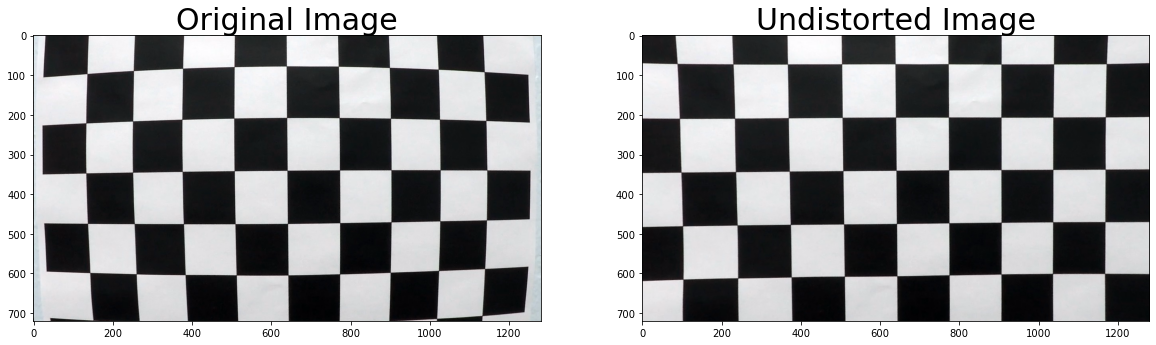

In [5]:
# Load a test image to undistort
dist_img = cv2.imread('camera_cal/calibration1.jpg')
## Call the function to calibrate camera and undistort image 
mtx, dist, undist_img = cal_undistort(dist_img, objpoints, imgpoints)

# Save camera calibration results for future use
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "camera_calibration_results.p", "wb" ) )

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(dist_img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(undist_img)
ax2.set_title('Undistorted Image', fontsize=30)

## **Step 2: Test Distortion Correction on Raw Images**
Test the distortion correction developed in the previous step to test for raw images in the folder test_images


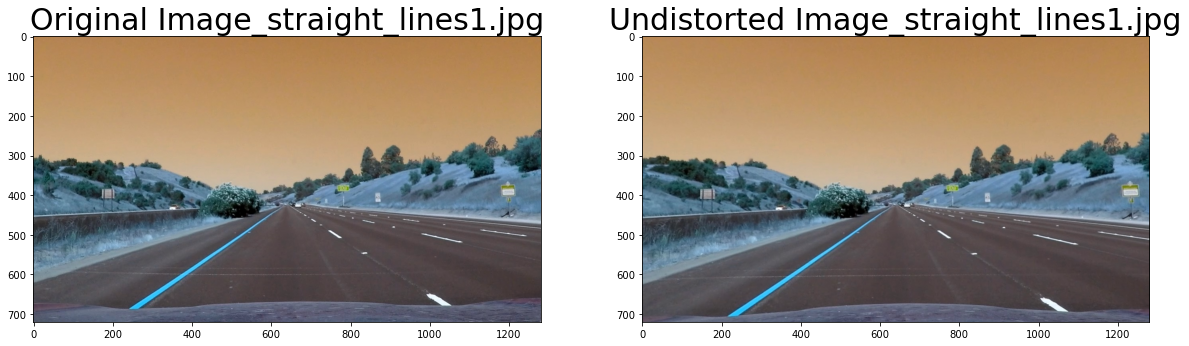

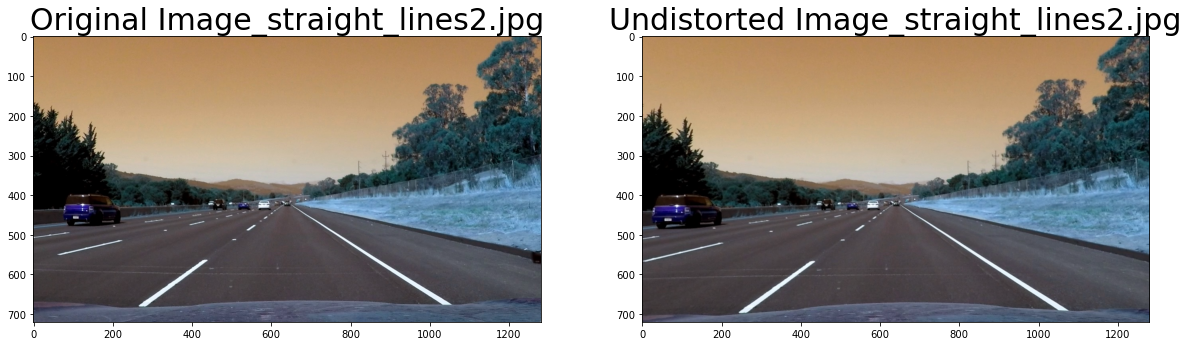

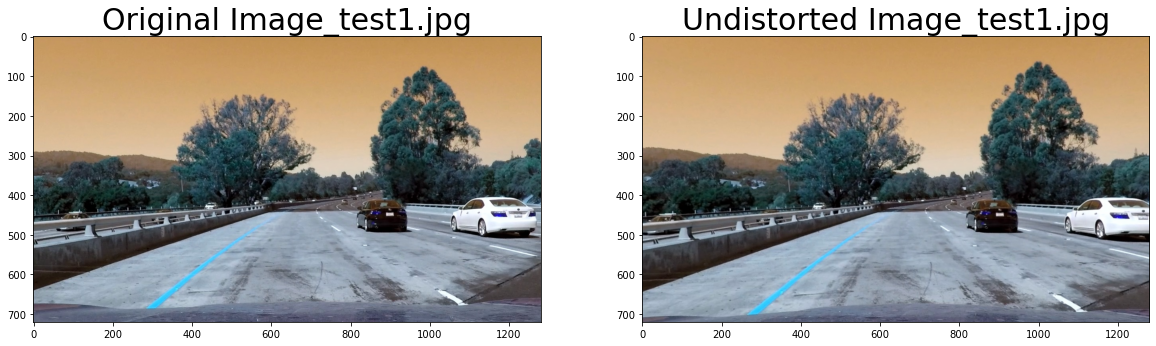

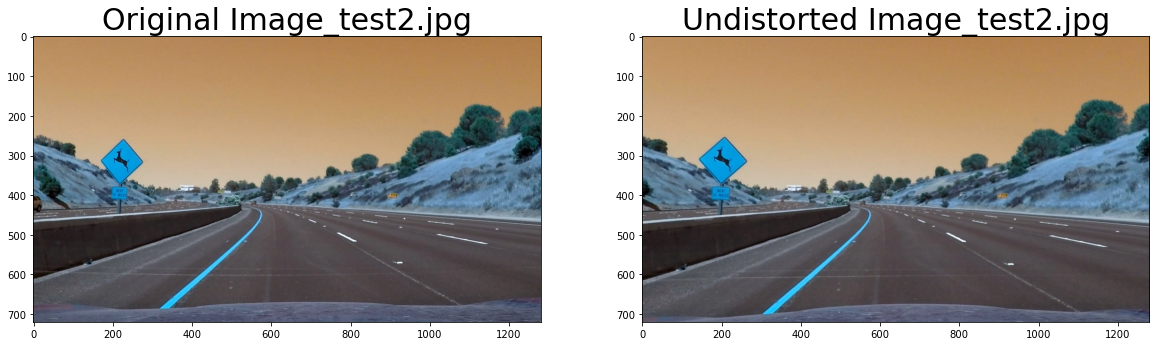

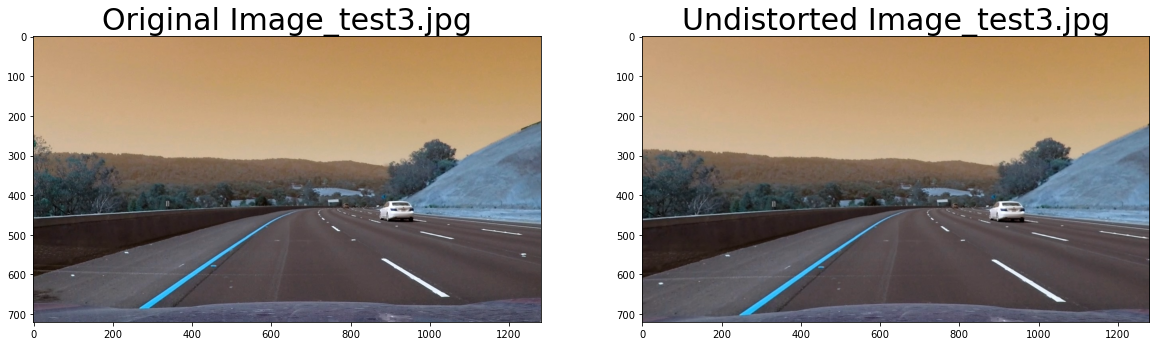

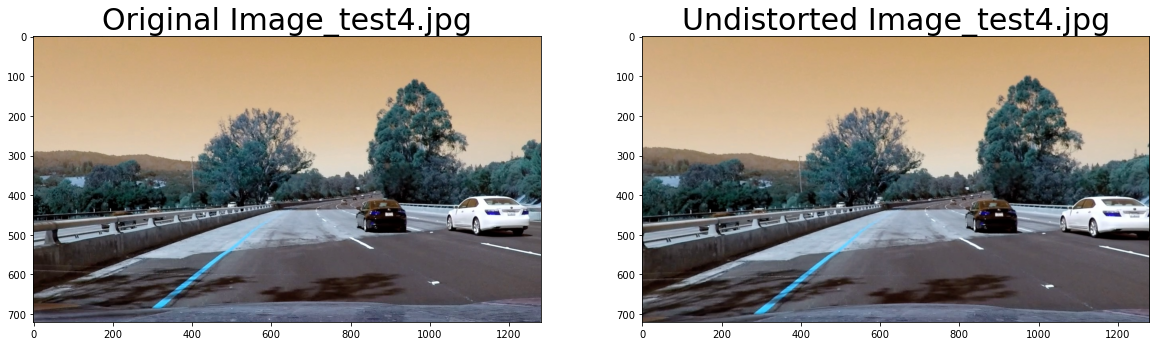

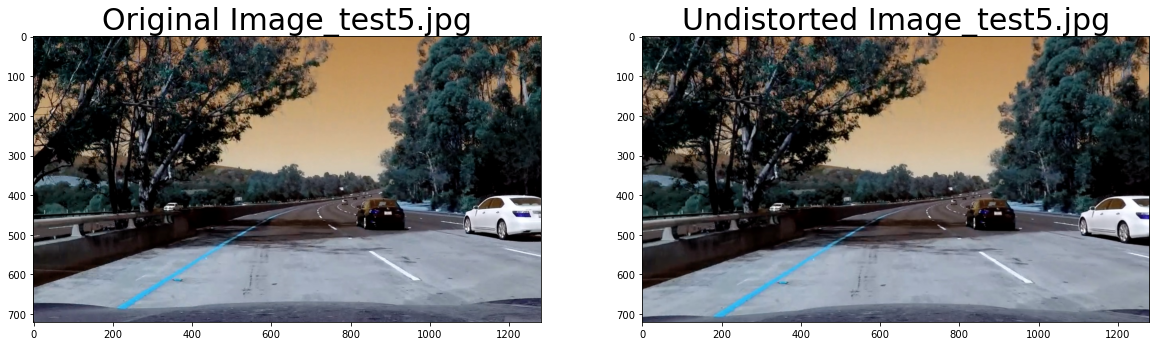

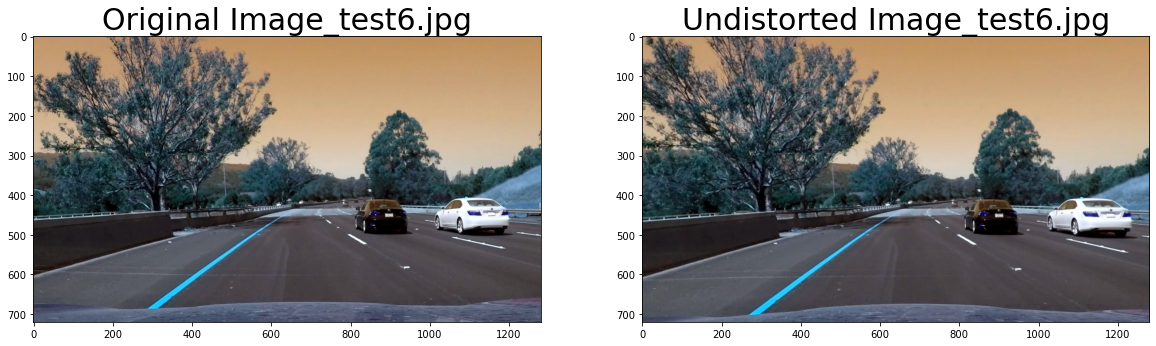

In [6]:
#raw=cv2.imread("test_images/test1.jpg")
pics=os.listdir("test_images/")

#Define function to undistort images. Created functions to call from anywhere in program
def img_dist(img):
    # Do not need to call the cal_distort function as you dont need to calibrate the camera everytime
    # Direct cal the cv2 undistort function with the camera matrix and distortion coefficients
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

for pic in pics:
    #print(pic)
    raw = cv2.imread("test_images/"+pic)
    undist_raw = img_dist(raw)
    
    ## Visualize undistortion
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.imshow(raw)
    ax1.set_title('Original Image_'+pic, fontsize=30)
    ax2.imshow(undist_raw)
    ax2.set_title('Undistorted Image_'+pic, fontsize=30)
    
#print(pics)

## **Step 3: Create Threshold Binary Image**
Apply color transform, gradients etc to create the required thresholded binary image to identify lane lines 

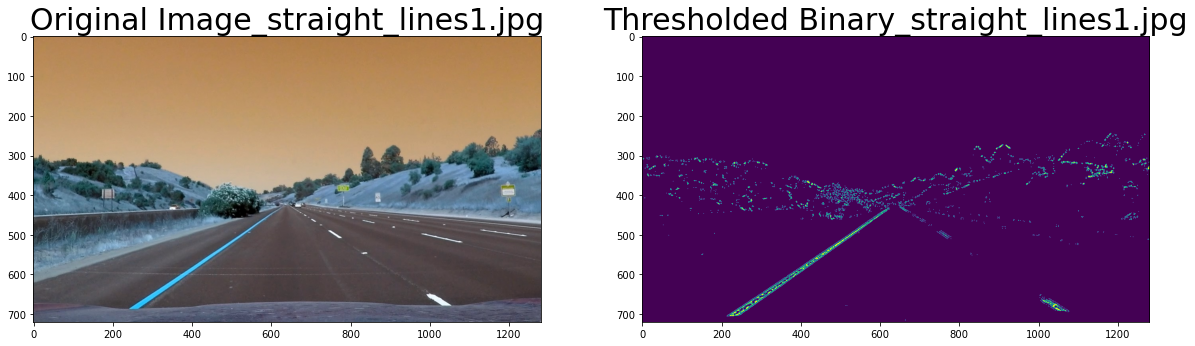

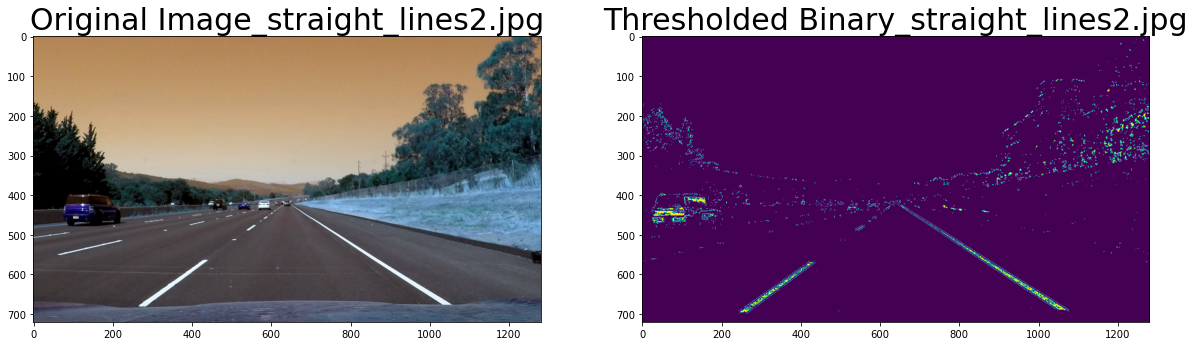

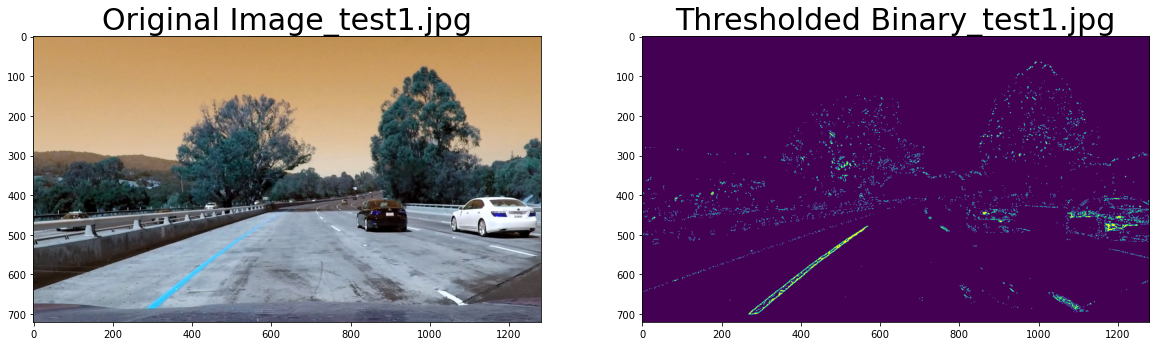

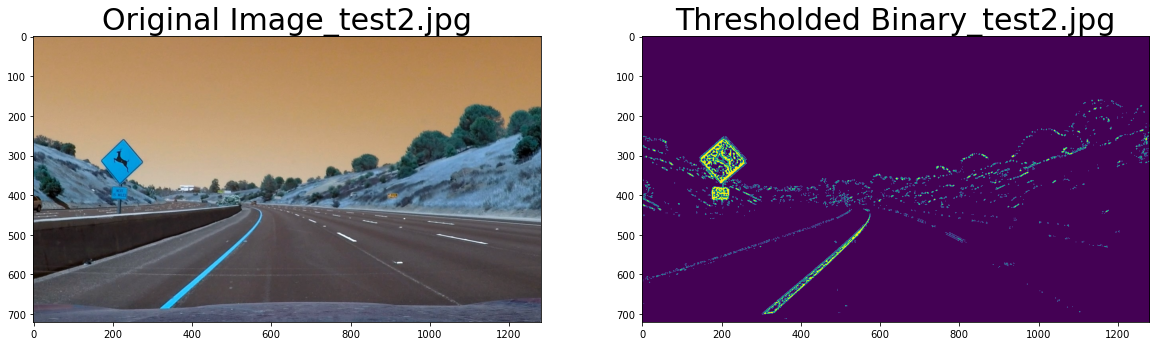

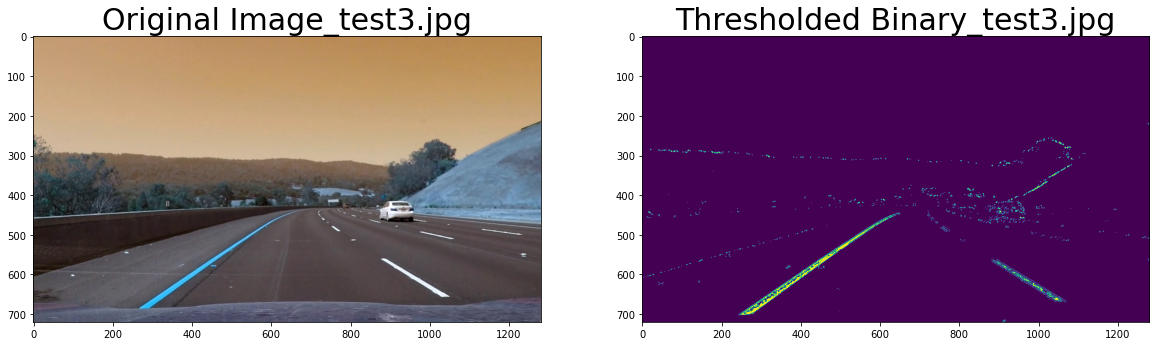

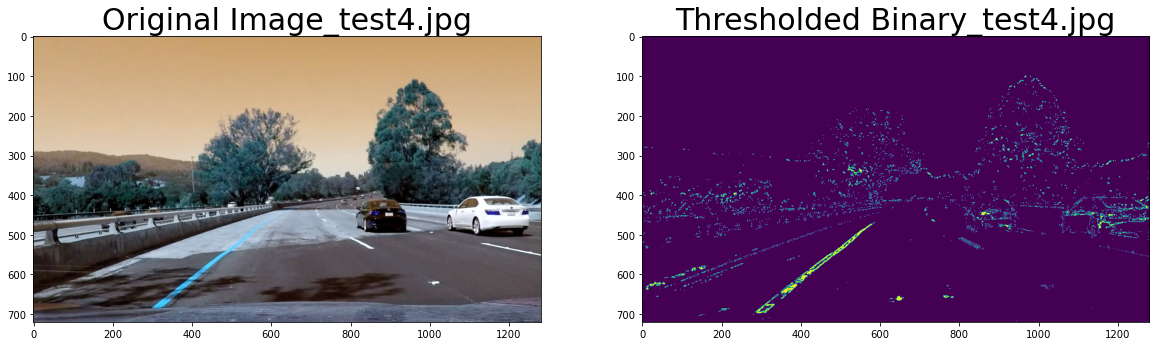

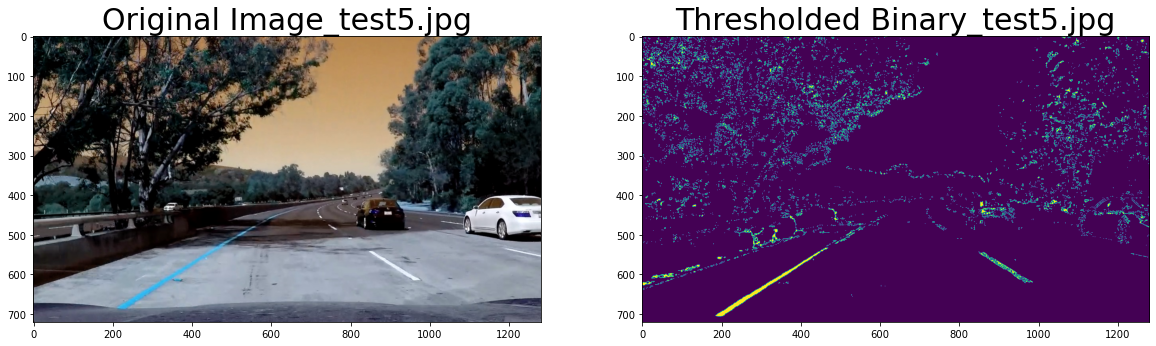

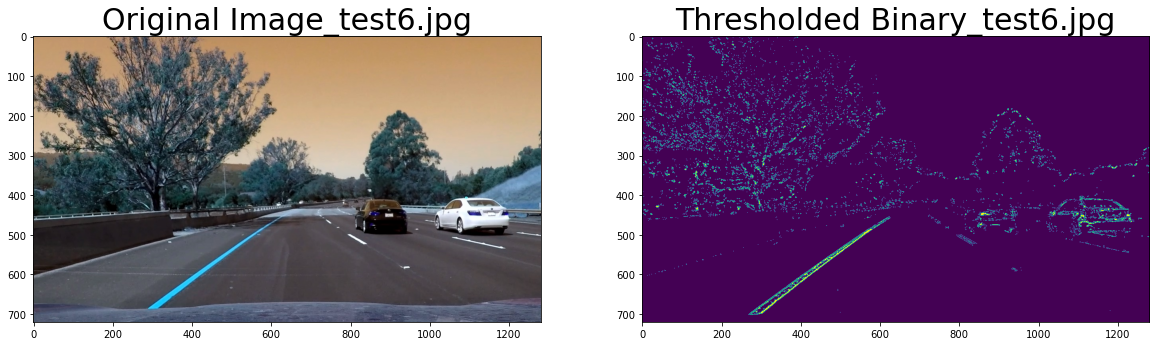

In [7]:
#img=cv2.imread("test_images/test1.jpg")
#plt.imshow(img)
ksize=5 # Define the Sobel kernel size

# Define function to create requried binary thresholed images
def gradient_color_thresh(img):
    # Apply Sobel and and magnitude gradient
    grad_binary = abs_sobel_thresh(img, orient='x', sobel_kernel=ksize, thresh=(30,150))
    mag_binary = mag_thresh(img, sobel_kernel=ksize, mag_thres=(50,100))
    dir_binary = dir_thresh(img, sobel_kernel=ksize, dir_thres=(0.7,1.3))
    # Apply Color threshold (along the s-channel in HLS color space)
    s_binary = hls_select(img,s_thresh=(175,250))

    # Combine both gradient & color threshold
    combined_binary = np.zeros_like(grad_binary)
    combined_binary[(((grad_binary == 1) & (mag_binary == 1) & (dir_binary == 1))| (s_binary == 1))] = 1
    #combined_binary[((grad_binary == 1) | (s_binary == 1))] = 1
    return combined_binary

for pic in pics:
    img = cv2.imread("test_images/"+pic)
    undist_img = img_dist(img)
    thresh_binary=gradient_color_thresh(undist_img)
    
    # Plot the result
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.imshow(img)
    ax1.set_title('Original Image_'+pic, fontsize=30)
    ax2.imshow(thresh_binary,)
    ax2.set_title('Thresholded Binary_'+pic, fontsize=30)

## **Step 4: Apply Perspective Transform on Undistorted Thresholded Binary Image to get Bird's Eye View**
Apply perspective tranform to the processed image to get Bird's eye view to track lane lines

Text(0.5, 1.0, 'Warped Binary_')

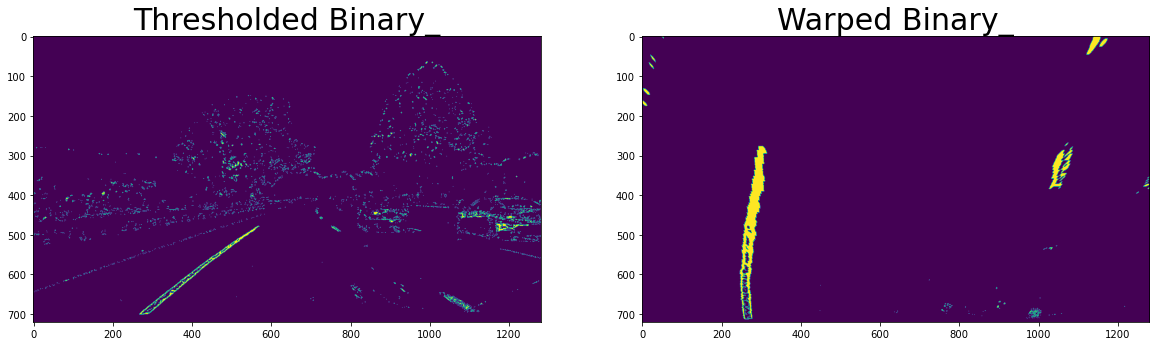

In [8]:
#img=mpimg.imread("test_images/test1.jpg")
img = cv2.imread("test_images/test1.jpg")
img_name = "test1" # Used for Plotting name. Change according to test image

undist_img = img_dist(img) # Undistort the image
thresh_binary=gradient_color_thresh(undist_img) #Binary Threshold the image

binary_warped, M = perspective_transform(thresh_binary)
#display(thresh_binary, 'Thresholded', binary_warped, 'Perspective Transform')

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(thresh_binary)
ax1.set_title('Thresholded Binary_', fontsize=30)
ax2.imshow(binary_warped)
ax2.set_title('Warped Binary_', fontsize=30)

# #define a perspective plotting function
# def pers_transform(img):
#     # Apply Undistortion function the img
#     undist_img = img_dist(img)
#     #thresh_binary=gradient_color_thresh(undist_img)
    
#     # Appply the perspective transform
#     #pers_img=perspective_transform(thresh_binary)
#     pers_img=perspective_transform(undist_img)
#     warped = pers_img['warped']
#     dst = pers_img['dst']
#     src = pers_img['src']
#     Minv = pers_img['Minv']
#     M = pres_img['M']

#     pts1 = np.array(src, np.int32)
#     pts1 = pts1.reshape((-1,1,2))
#     cv2.polylines(undist_img,[pts1],True,(255,0,0),3)

#     pts2 = np.array(dst, np.int32)
#     pts2 = pts2.reshape((-1,1,2))
#     cv2.polylines(warped,[pts2],True,(255,0,0),3)

#     # Visualize perspective transform
#     f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
#     ax1.imshow(undist_img)
#     ax1.set_title('Original Image_'+pic, fontsize=30)
#     ax2.imshow(warped)
#     ax2.set_title('After Perspective Transform_'+pic, fontsize=30)
    
# for pic in pics:
#     img = mpimg.imread("test_images/"+pic)
#     persp_img = pers_transform(img)

## **Step 5: Find lane pixels and lane boundary**
Peak histogram techqnique is used to extract the actual lane lines. Two steps are followed here.
1. Search for lane line pizels across the images using histogram (sliding window technique). Curve fit the pixels to obtain the lane lines. Store the lane line parameters in the class Line ()
2. Use the stored lane line parameters to draw selection window on the original image.Use this for future images

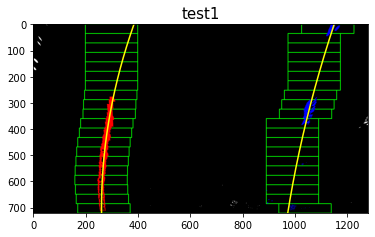

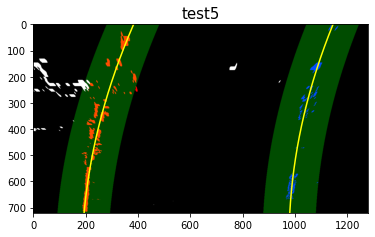

In [9]:
# Define class Line() to store relevant lane line information
class Line():
    # We use this class to hold the details of the located lines and polynomial fit for each image.
    def __init__(self):
        self.fullsearch = False  
        self.left_lane_inds = None 
        self.right_lane_inds = None   
        self.left_fit = None  
        self.right_fit = None 
        self.left_fit_cr = None  
        self.right_fit_cr = None 
        self.yvals = None
        self.left_fitx = None
        self.right_fitx = None
        self.y_bottom = None
        self.y_top = None
        self.left_x_bottom = None
        self.left_x_top = None
        self.right_x_bottom = None
        self.right_x_top = None
        self.left_curverads = None
        self.right_curverads = None
        self.mean_left_curverad = None
        self.mean_right_curverad = None

# 1. Initial search. Use sliding windows for this method
left_lane_inds, right_lane_inds, out_img = Initial_find_line_pixels(binary_warped)
line = process_fit(binary_warped, left_lane_inds, right_lane_inds)
fit_poly(binary_warped, left_lane_inds, right_lane_inds, out_img, False,img_name)

# 2. Search for lane lines from prior stored values. Replace sliding windows with polygon
# Testing feature with another test image
img=mpimg.imread("test_images/test5.jpg")
img_name = "test5" # Used for Plotting name. Change according to test image

# Perform Undistortion, binary thresholding & perspective transformation
undist_img = img_dist(img) # Undistort the image
thresh_binary=gradient_color_thresh(undist_img) #Binary Threshold the image
binary_warped, M = perspective_transform(thresh_binary)

left_lane_inds, right_lane_inds, out_img = find_lines_prior(binary_warped, line.left_fit, line.right_fit)
line = process_fit(binary_warped, left_lane_inds, right_lane_inds)
fit_poly(binary_warped, left_lane_inds, right_lane_inds, out_img, True,img_name)

## **Step 6 - 8: Determine the curvature of the lane and vehicle position with respect to center. Ouput all relevant information on final image with lane boundaries**



Use the above defined functions to calculate the radius of curvature and display the lane boundaries on the original image

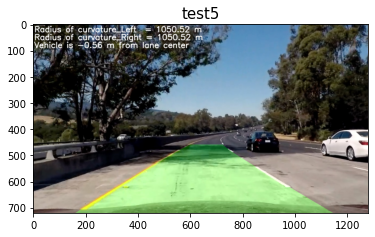

In [11]:
# Call the function to draw the calculated lane lines on the original image
result = draw_lines(undist_img, binary_warped, line.yvals, line.left_fitx, line.right_fitx, np.linalg.inv(M))
final_result = annotate_result(result, line)
plt.imshow(result)
plt.title(img_name, fontsize=15)
plt.show()

## **Step 9: Implement the developed Pipeline on Video**

Used python script to define all the required functions as a pipeline to process the video

In [11]:
output = process_video()
print(output)
# HTML("""
# <video width="960" height="540" controls>
#   <source src="{0}">
# </video>
# """.format(output))

t:   0%|                                                                            | 0/1260 [00:00<?, ?it/s, now=None]

Moviepy - Building video project_video_output.mp4.
Moviepy - Writing video project_video_output.mp4



Moviepy - Done !
Moviepy - video ready project_video_output.mp4


t:   0%|                                                                             | 0/485 [00:00<?, ?it/s, now=None]

Moviepy - Building video challenge_video_output.mp4.
Moviepy - Writing video challenge_video_output.mp4



Moviepy - Done !
Moviepy - video ready challenge_video_output.mp4


t:   0%|                                                                            | 0/1199 [00:00<?, ?it/s, now=None]

Moviepy - Building video harder_challenge_video_output.mp4.
Moviepy - Writing video harder_challenge_video_output.mp4



Moviepy - Done !
Moviepy - video ready harder_challenge_video_output.mp4
Num full searches 1940
('project_video_output.mp4', 'challenge_video_output.mp4', 'harder_challenge_video_output.mp4')
